In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import psutil

In [6]:
stocks = ['TLT', 'LQD', 'SMH', 'XLV', 'XLI', 'GLD']
data = yf.download(stocks, start='2000-01-01', end='2023-04-30')
data = data['Adj Close']
returns = data.pct_change()

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq', 'fun': check_sum})
bounds = tuple((0, 1) for i in range(len(stocks)))
init_guess = len(stocks)*[1/len(stocks)]
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
optimal_weights = opt_results.x


[*********************100%***********************]  6 of 6 completed


In [7]:
optimal_portfolio = get_ret_vol_sr(optimal_weights)
print('Optimal weights:', optimal_weights)
print('Optimal portfolio:', optimal_portfolio)
frontier_y = np.linspace(0,0.3,100) 
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

Optimal weights: [0.20091916 0.26930493 0.         0.23405746 0.08999247 0.20572597]
Optimal portfolio: [0.07347484 0.08024675 0.91561139]


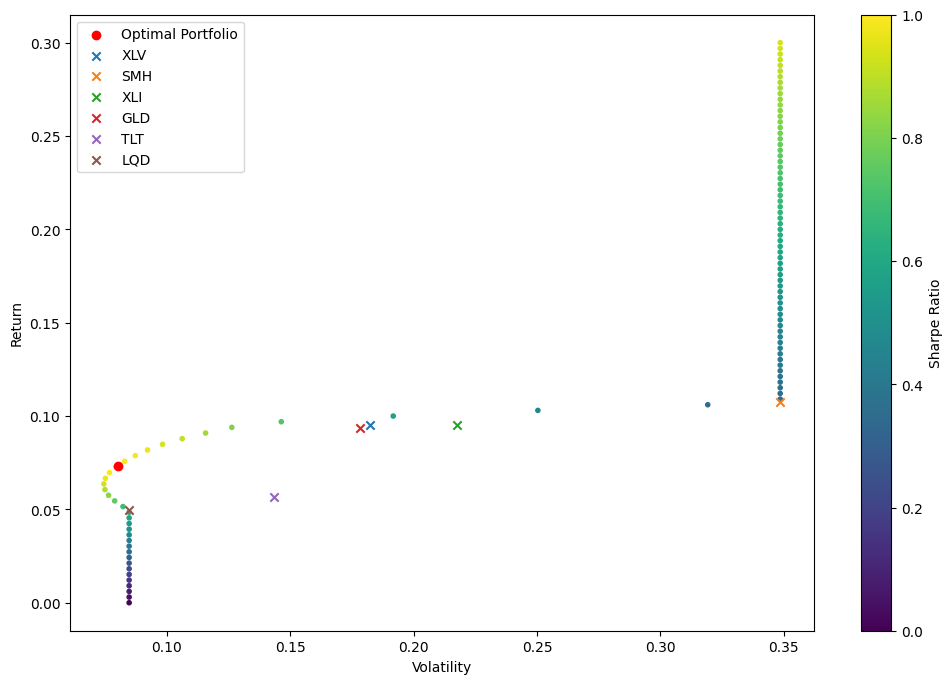

In [8]:
expected_returns = returns.mean() * 252
volatilities = returns.std() * np.sqrt(252)

plt.figure(figsize=(12,8))
plt.scatter(frontier_volatility, frontier_y, c=(frontier_y)/frontier_volatility, marker='.')
plt.scatter(optimal_portfolio[1], optimal_portfolio[0], color='r', label='Optimal Portfolio')
for asset in ['XLV', 'SMH', 'XLI', 'GLD', 'TLT', 'LQD']:
    plt.scatter(volatilities[asset], expected_returns[asset], marker='x', label=asset)

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

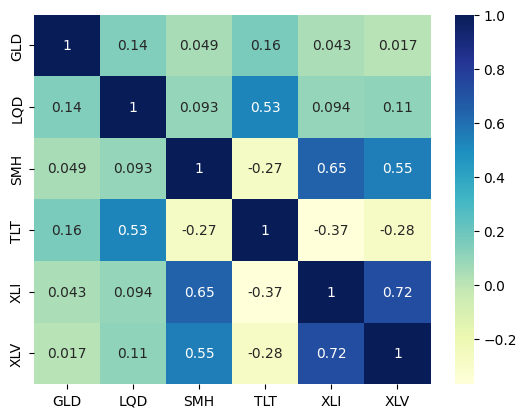

In [9]:
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

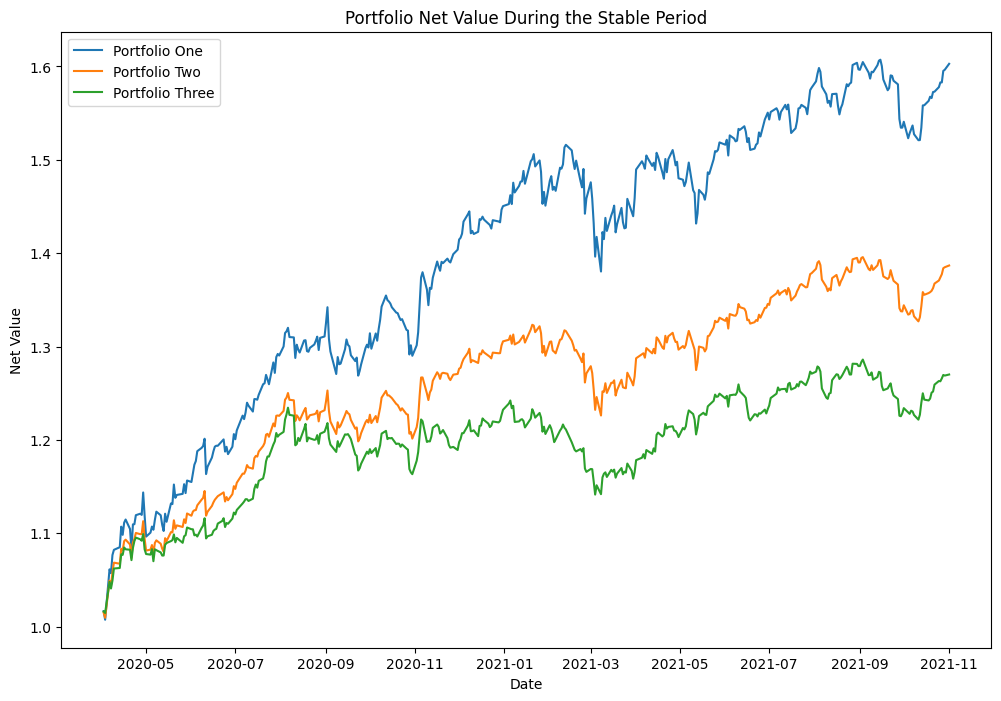

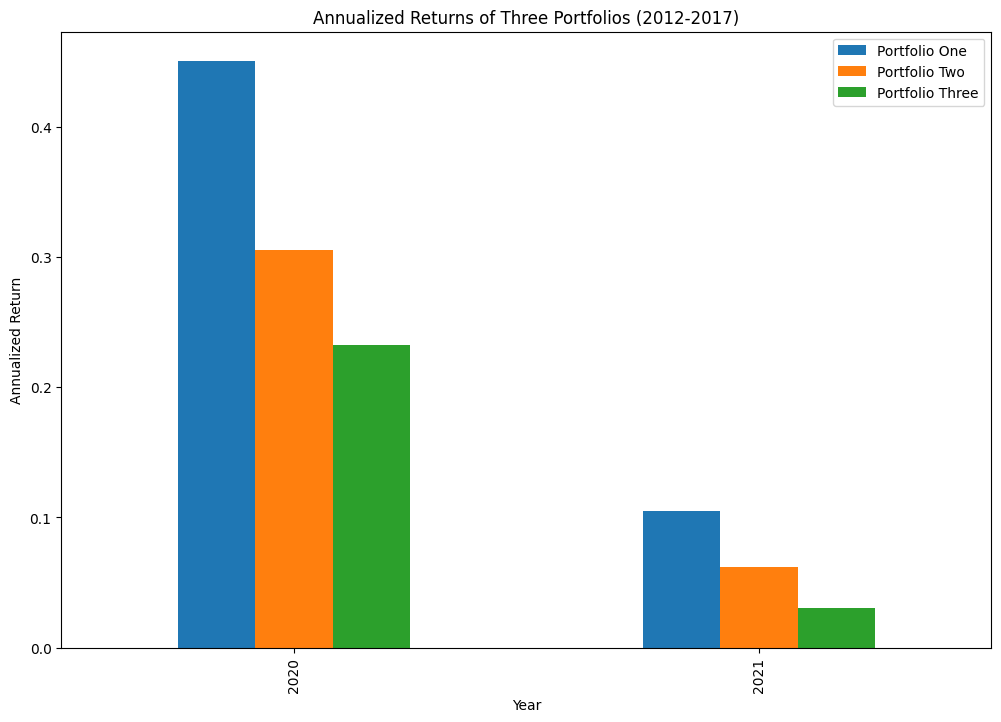

In [10]:
portfolio_weights_one = [0.15, 0.2, 0.4, 0.15, 0.05, 0.05]
portfolio_weights_two = [0.2, 0.15, 0.2, 0.25, 0.08, 0.12]
portfolio_weights_three = [0.4, 0.0, 0.05, 0.25, 0.1, 0.2]
stable_period_growth = data[(data.index >= '2020-04-01') & (data.index <= '2021-11-01')]
stable_returns_growth = stable_period_growth.pct_change()
stable_net_value_one = (1 + stable_returns_growth.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_growth.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_growth.dot(portfolio_weights_three)).cumprod()

plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()

annual_returns_one = stable_returns_growth.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_growth.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_growth.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)

annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [11]:
print('Portfolio_one :')
annual_return_one = stable_returns_growth.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)
std_dev_one = stable_returns_growth.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)
rf_rate = 0.02 
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)
cum_returns_one = stable_returns_growth.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')
annual_return_two = stable_returns_growth.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)
std_dev_two = stable_returns_growth.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)
rf_rate = 0.02 
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)
cum_returns_two = stable_returns_growth.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')
annual_return_three = stable_returns_growth.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)
std_dev_three = stable_returns_growth.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)
cum_returns_three = stable_returns_growth.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)

Portfolio_one :
Annualized Return for Portfolio One: 0.30859335097620133
Standard Deviation for Portfolio One: 0.14997285527891294
Sharpe Ratio for Portfolio One: 1.924303904459831
Max Drawdown for Portfolio One: -0.08949617121944725
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: 0.21192690442348228
Standard Deviation for Portfolio Two: 0.10789762003469211
Sharpe Ratio for Portfolio Two: 1.7787871906884731
Max Drawdown for Portfolio Two: -0.07339468843630352
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.1555767074934508
Standard Deviation for Portfolio Three: 0.09894658911933243
Sharpe Ratio for Portfolio Three: 1.3702009205182544
Max Drawdown for Portfolio Three: -0.08107829495781678


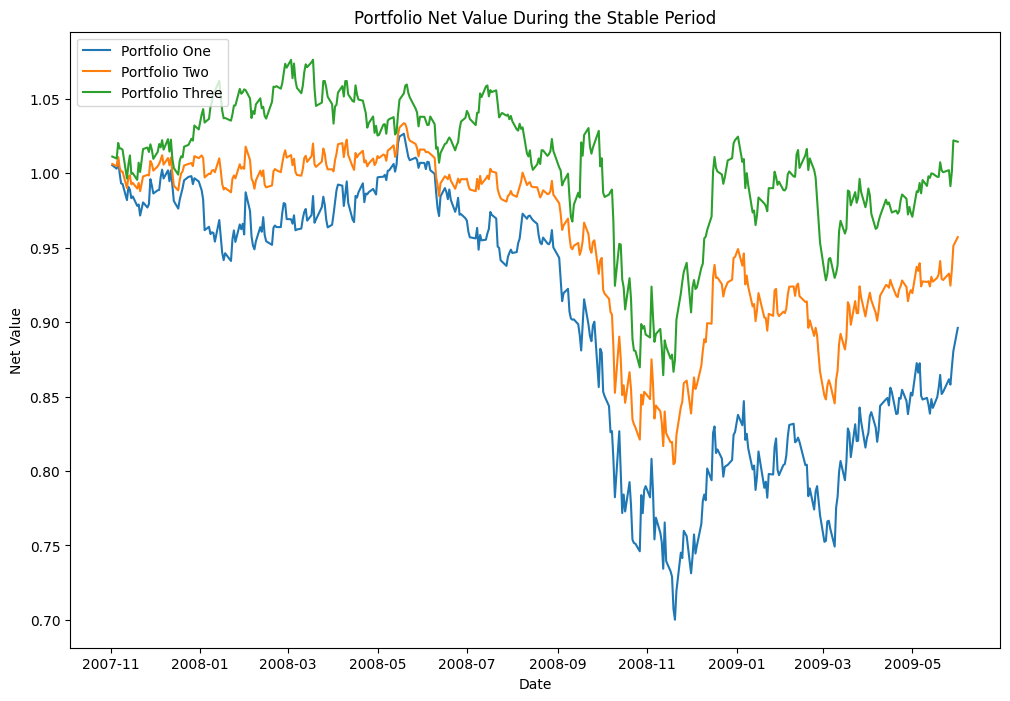

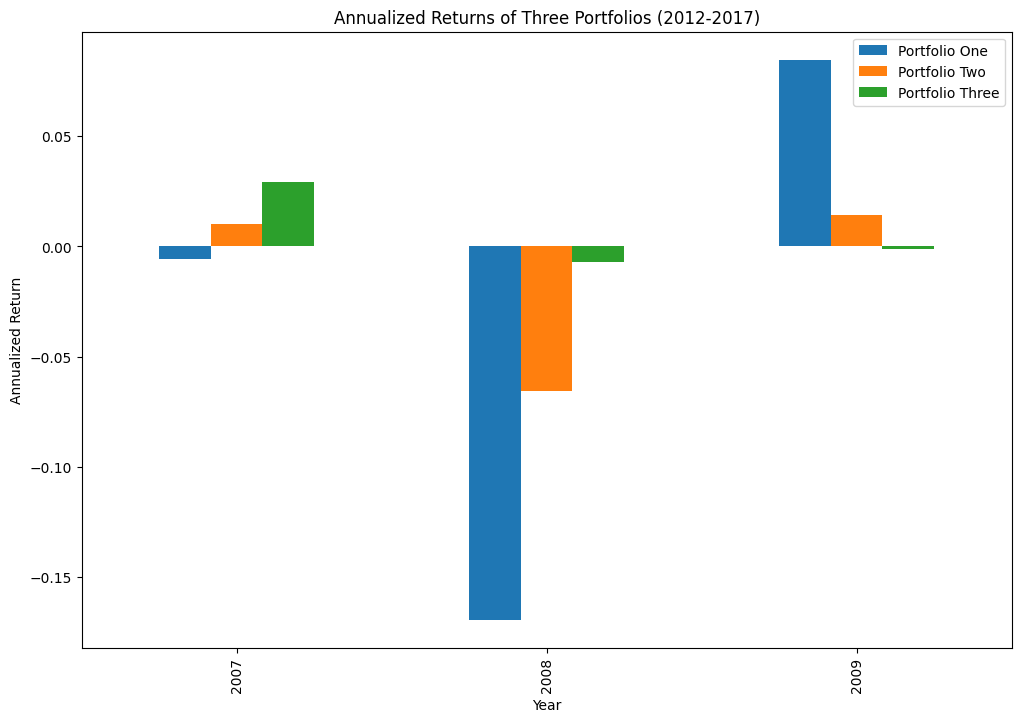

In [12]:
stable_period_recession = data[(data.index >= '2007-11-01') & (data.index <= '2009-06-01')]
stable_returns_recession = stable_period_recession.pct_change()
stable_net_value_one = (1 + stable_returns_recession.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_recession.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_recession.dot(portfolio_weights_three)).cumprod()
plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()

annual_returns_one = stable_returns_recession.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_recession.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_recession.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)

annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [13]:
stable_period_recession = data[(data.index >= '2007-11-01') & (data.index <= '2009-06-01')]
stable_returns_recession = stable_period_recession.pct_change()

print('Portfolio_one :')
annual_return_one = stable_returns_recession.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)
std_dev_one = stable_returns_recession.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)
rf_rate = 0.02  
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)
cum_returns_one = stable_returns_recession.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')
annual_return_two = stable_returns_recession.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)
std_dev_two = stable_returns_recession.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)
cum_returns_two = stable_returns_recession.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')
annual_return_three = stable_returns_recession.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)
std_dev_three = stable_returns_recession.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)
cum_returns_three = stable_returns_recession.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)

Portfolio_one :
Annualized Return for Portfolio One: -0.04758650312875899
Standard Deviation for Portfolio One: 0.2112970492755428
Sharpe Ratio for Portfolio One: -0.31986486967275407
Max Drawdown for Portfolio One: -0.31794605289688954
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: -0.01670096087454489
Standard Deviation for Portfolio Two: 0.1502216618627822
Sharpe Ratio for Portfolio Two: -0.24431204141563048
Max Drawdown for Portfolio Two: -0.22159673760712673
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.02530577164495374
Standard Deviation for Portfolio Three: 0.15523819813011078
Sharpe Ratio for Portfolio Three: 0.03417826094906603
Max Drawdown for Portfolio Three: -0.1968450421866936


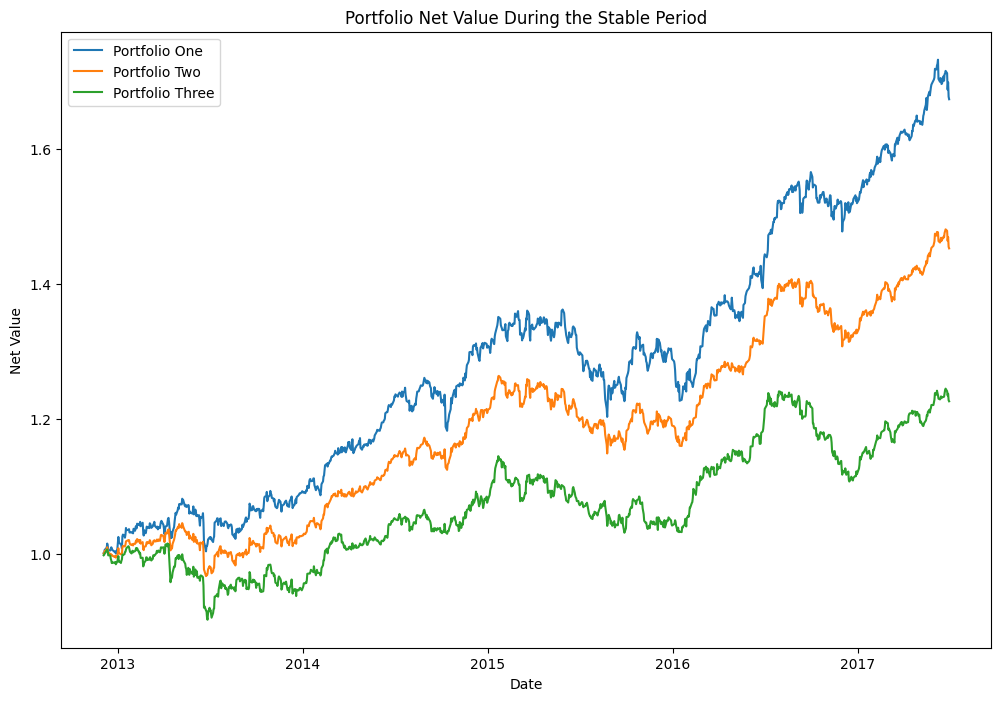

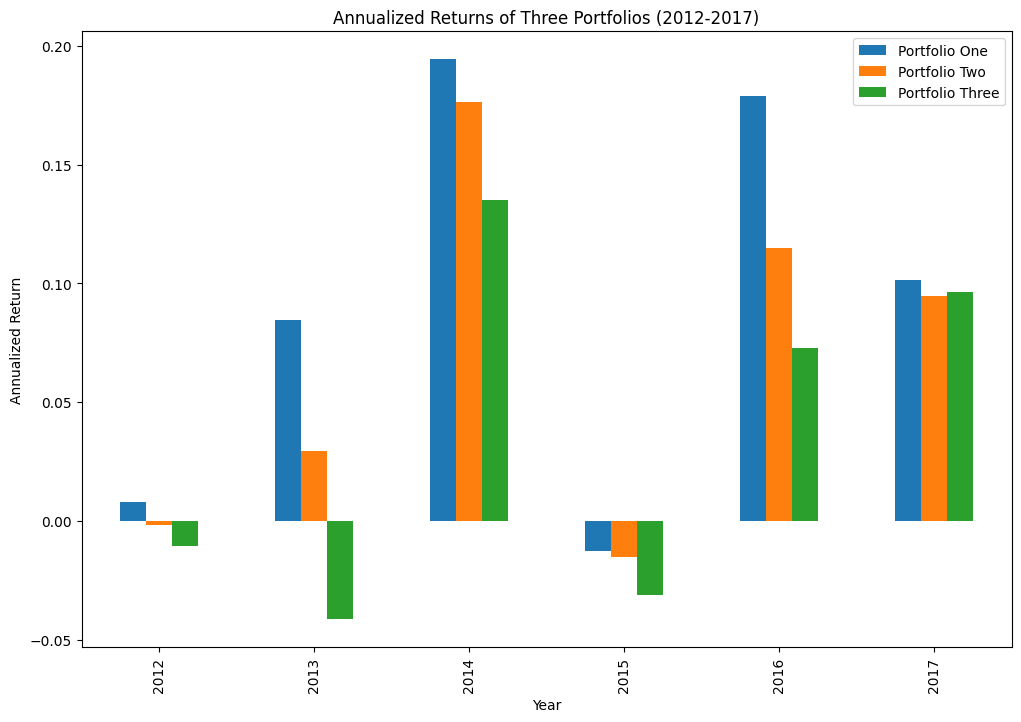

In [14]:
stable_period_stable = data[(data.index >= '2012-12-01') & (data.index <= '2017-06-30')]
stable_returns_stable = stable_period_stable.pct_change()
stable_net_value_one = (1 + stable_returns_stable.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_stable.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_stable.dot(portfolio_weights_three)).cumprod()
plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()
annual_returns_one = stable_returns_stable.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_stable.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_stable.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [15]:
stable_period_stable = data[(data.index >= '2010-01-01') & (data.index <= '2011-12-31')]
stable_returns_stable = stable_period_stable.pct_change()

print('Portfolio_one :')
annual_return_one = stable_returns_stable.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)
std_dev_one = stable_returns_stable.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)
rf_rate = 0.02
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)
cum_returns_one = stable_returns_stable.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')
annual_return_two = stable_returns_stable.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)
std_dev_two = stable_returns_stable.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)
cum_returns_two = stable_returns_stable.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')
annual_return_three = stable_returns_stable.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)
std_dev_three = stable_returns_stable.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)
cum_returns_three = stable_returns_stable.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)


Portfolio_one :
Annualized Return for Portfolio One: 0.1154799466853839
Standard Deviation for Portfolio One: 0.11915377482375923
Sharpe Ratio for Portfolio One: 0.8013170109516767
Max Drawdown for Portfolio One: -0.07909523585883037
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: 0.13639182895916882
Standard Deviation for Portfolio Two: 0.08723809555407941
Sharpe Ratio for Portfolio Two: 1.3341858074723425
Max Drawdown for Portfolio Two: -0.04793896699745616
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.15754946811384513
Standard Deviation for Portfolio Three: 0.0974708248416028
Sharpe Ratio for Portfolio Three: 1.4111860481059133
Max Drawdown for Portfolio Three: -0.054435778125363356


In [16]:
sample_period = data[(data.index >= '2005-01-01') & (data.index <= '2022-12-31')]
returns = sample_period.pct_change()

# Portfolio 1
annual_return_one = returns.dot(portfolio_weights_one).mean() * 252
annual_std_dev_one = returns.dot(portfolio_weights_one).std() * np.sqrt(252)

# Portfolio 2
annual_return_two = returns.dot(portfolio_weights_two).mean() * 252
annual_std_dev_two = returns.dot(portfolio_weights_two).std() * np.sqrt(252)

# Portfolio 3
annual_return_three = returns.dot(portfolio_weights_three).mean() * 252
annual_std_dev_three = returns.dot(portfolio_weights_three).std() * np.sqrt(252)

n_simulations = 10000
n_trading_days = 252
n_years = 5

def simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return, annual_std_dev):
    final_returns = []
    max_drawdowns = []
    for _ in range(n_simulations):
        daily_returns = np.random.normal(annual_return/n_trading_days, annual_std_dev/np.sqrt(n_trading_days), n_trading_days*n_years) + 1
        price_path = np.cumprod(daily_returns)
        peak = np.maximum.accumulate(price_path)
        drawdown = (price_path - peak) / peak
        max_drawdown = drawdown.min()
        final_return = price_path[-1]

        final_returns.append(final_return)
        max_drawdowns.append(max_drawdown)
        
    return final_returns, max_drawdowns

final_returns_one, max_drawdowns_one = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_one, annual_std_dev_one)
final_returns_two, max_drawdowns_two = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_two, annual_std_dev_two)
final_returns_three, max_drawdowns_three = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_three, annual_std_dev_three)

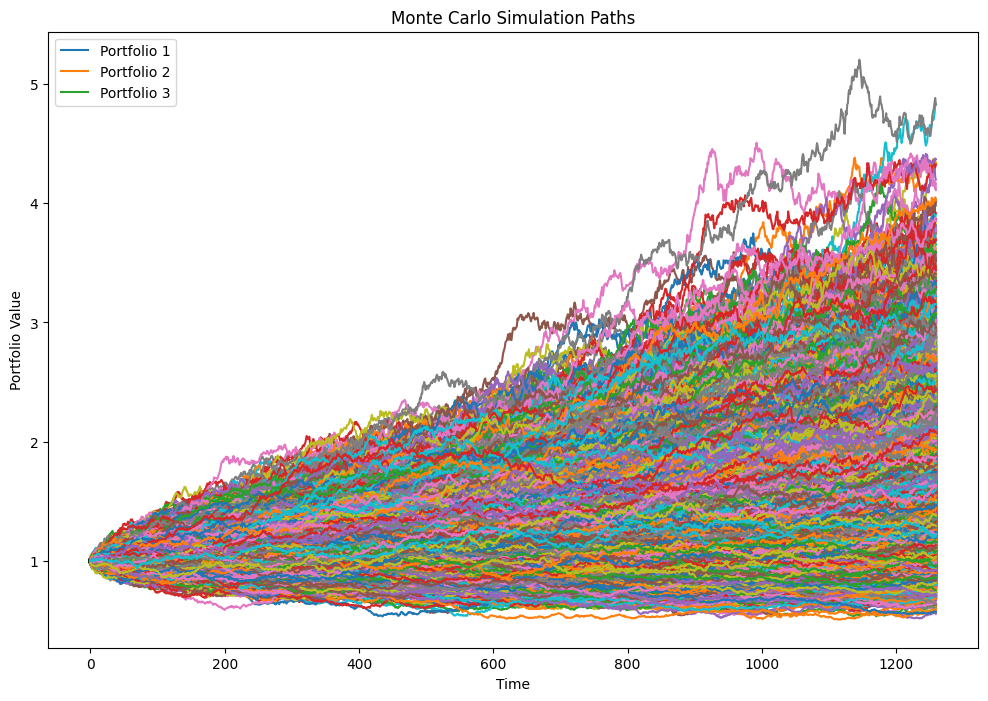

In [17]:
plt.figure(figsize=(12, 8))

# Portfolio 1
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_one / n_trading_days, annual_std_dev_one / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

# Portfolio 2
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_two / n_trading_days, annual_std_dev_two / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

# Portfolio 3
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_three / n_trading_days, annual_std_dev_three / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Monte Carlo Simulation Paths')
plt.legend(['Portfolio 1', 'Portfolio 2', 'Portfolio 3'])
plt.show()


In [18]:
cpu_usage = psutil.cpu_percent(interval=1)
memory = psutil.virtual_memory()
total_memory = round(memory.total / (1024 ** 3), 2)  # 總記憶體（GB）
available_memory = round(memory.available / (1024 ** 3), 2)  # 可用記憶體（GB）
disk_usage = psutil.disk_usage('/')
total_disk_space = round(disk_usage.total / (1024 ** 3), 2)  # 總硬碟空間（GB）
used_disk_space = round(disk_usage.used / (1024 ** 3), 2)  # 已使用硬碟空間（GB）
network = psutil.net_io_counters()
sent_bytes = round(network.bytes_sent / (1024 ** 2), 2)  # 已發送數據量（MB）
received_bytes = round(network.bytes_recv / (1024 ** 2), 2)  # 已接收數據量（MB）

print('CPU Usage:', cpu_usage, '%')
print('Total Memory:', total_memory, 'GB')
print('Available Memory:', available_memory, 'GB')
print('Total Disk Space:', total_disk_space, 'GB')
print('Used Disk Space:', used_disk_space, 'GB')
print('Sent Bytes:', sent_bytes, 'MB')
print('Received Bytes:', received_bytes, 'MB')

CPU Usage: 16.5 %
Total Memory: 8.0 GB
Available Memory: 1.26 GB
Total Disk Space: 228.27 GB
Used Disk Space: 8.46 GB
Sent Bytes: 339.22 MB
Received Bytes: 14251.29 MB
